# Cybersecurity Intrusion Detection

In [217]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score,accuracy_score
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

In [218]:
df = pd.read_csv('cybersecurity_intrusion_data.csv')

# Cybersecurity Intrusion Detection

## 1. Descriptive Analysis

In [219]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (9537, 11)


The dataset contains 9537 rows and 11 features.

The dataset includes network and user behavior features used to detect potential cybersecurity intrusions. Each row represents a signle network session, and the target variable indicates whether the session was normal or an attack.

The variables of the dataset are :
- session_id : unique identifier for each network session
- network_packet_size : size of network packets in bytes
- protocol_type : communication protocol used (TCP, UDP, ICMP)
- login_attemps : number of login attemps in a session
- session_duration : duration of the session in seconds
- encryption_used : encryption protocol used (AES, DES)
- ip_reputation_score : trust score of the IP address (between 0 and 1) --> the closer this score is to 1, the more suspicious it is
- failed_logins : number of failed login attemps
- browser_type : type of browser used (Chrome, Firefox, Edge, Safari)
- unusual_time_access : binary indicator (0 or 1) showing if the access occured at an unusual time
- attack_detected (target variable) : 1 means attack detected and 0 means normal activity

**Overview of the dataset :**

In [220]:
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [221]:
df.dtypes

session_id              object
network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object

In [222]:
df.describe()

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000
mean,500.430639,4.032086,792.745312,0.331338,1.517773,0.149942,0.447101
std,198.379364,1.963012,786.560144,0.177175,1.033988,0.357034,0.497220
min,64.000000,1.000000,0.500000,0.002497,0.000000,0.000000,0.000000
25%,365.000000,3.000000,231.953006,0.191946,1.000000,0.000000,0.000000
50%,499.000000,4.000000,556.277457,0.314778,1.000000,0.000000,0.000000
75%,635.000000,5.000000,1105.380602,0.453388,2.000000,0.000000,1.000000
max,1285.000000,13.000000,7190.392213,0.924299,5.000000,1.000000,1.000000


The summary statistics provide an overview of the numerical features in the dataset :
- On average, users make around 4 login attemps, which suggests normal authentification behavior, though some reach up to 13 attempts (possible brute-force indicators)
- The session duration varies greatly (from less than 1 second to over 7000 seconds) : long sessions may suggest persistent access or suspicious activity
- The IP reputation score ranges from 0 to 0.92, with an average around 0.33 showing that most IPs are relatively trustworthy but a few are risky.
- The average number of failed login attemps is 1.5 with a maximum of 5 : the highest values could be linked to cyberattacks

**Check for missing values :**

In [223]:
print(df.isnull().sum())

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


We can see that there are 1,966 missing values in the dataset.

**Check class imbalance :**

Class distribution:
 attack_detected
0    5273
1    4264
Name: count, dtype: int64
Imbalance ratio ≈ 1:1.24


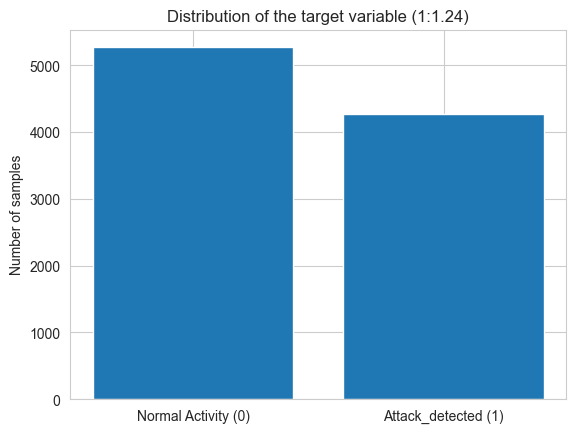

In [224]:
class_counts = df['attack_detected'].value_counts()
print("Class distribution:\n", class_counts)

minority = class_counts.min()
majority = class_counts.max()
ratio = majority / minority
print(f"Imbalance ratio ≈ 1:{ratio:.2f}")

plt.bar(['Normal Activity (0)', 'Attack_detected (1)'], class_counts)
plt.title(f"Distribution of the target variable (1:{ratio:.2f})")
plt.ylabel("Number of samples")
plt.show()

### Numerical features

**Correlation matrix**

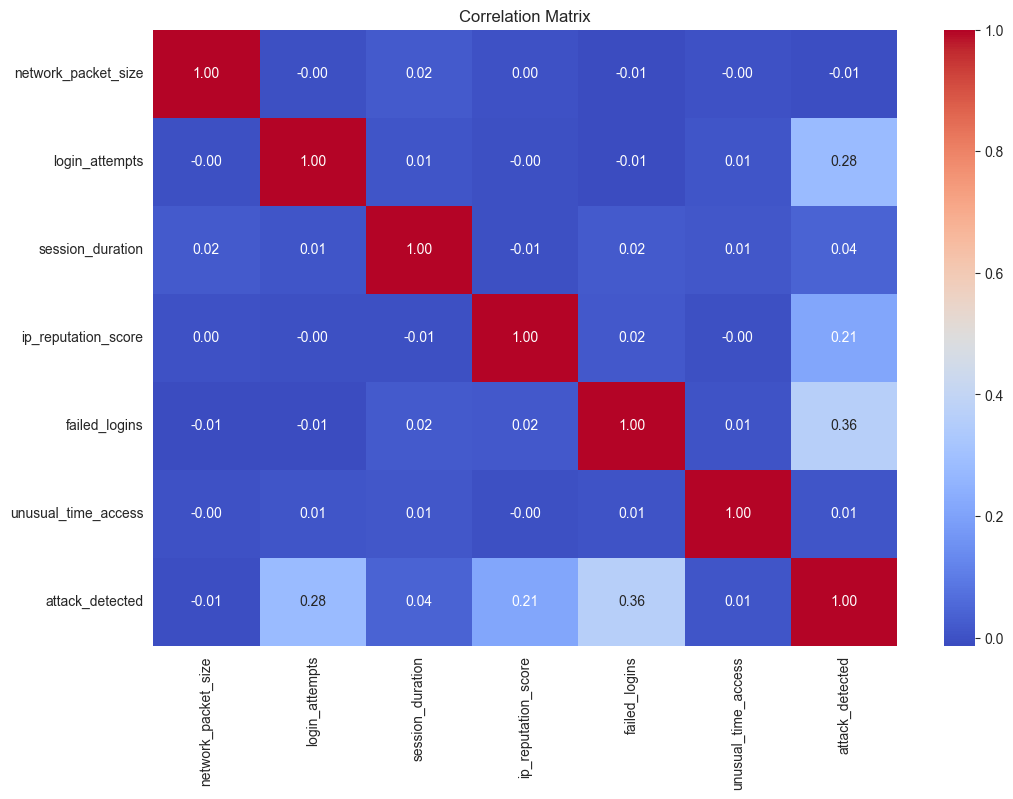

In [225]:
# Sélection des colonnes numériques
numeric_cols = df.select_dtypes(include=np.number)

# Matrice de corrélation
plt.figure(figsize=(12,8))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The correlation matrix highlights that the variables failed_logins (0.36), login_attempts (0.28) and ip_reputation_score (0.21) are those with the strongest links to the target variable attack_detected. This suggests that a significant number of failed logins or login attempts increases the probability of an attack being detected. Inversely, variables such as network_packet_size, session_duration, and unusual_time_access show correlations close to zero, indicating no significant linear relationship with attack detection.

In this analysis, we tested several resampling techniques. However, the data is nearly balanced (imbalance ratio = 1:1.24), and resampling did not improve model performance. Therefore, we decided not to apply resampling in the upcoming models.

**Correlation matrix of the numerical features and the target**

attack_detected        1.000000
failed_logins          0.363726
login_attempts         0.277320
ip_reputation_score    0.211540
session_duration       0.041602
unusual_time_access    0.008652
network_packet_size   -0.006798
Name: attack_detected, dtype: float64


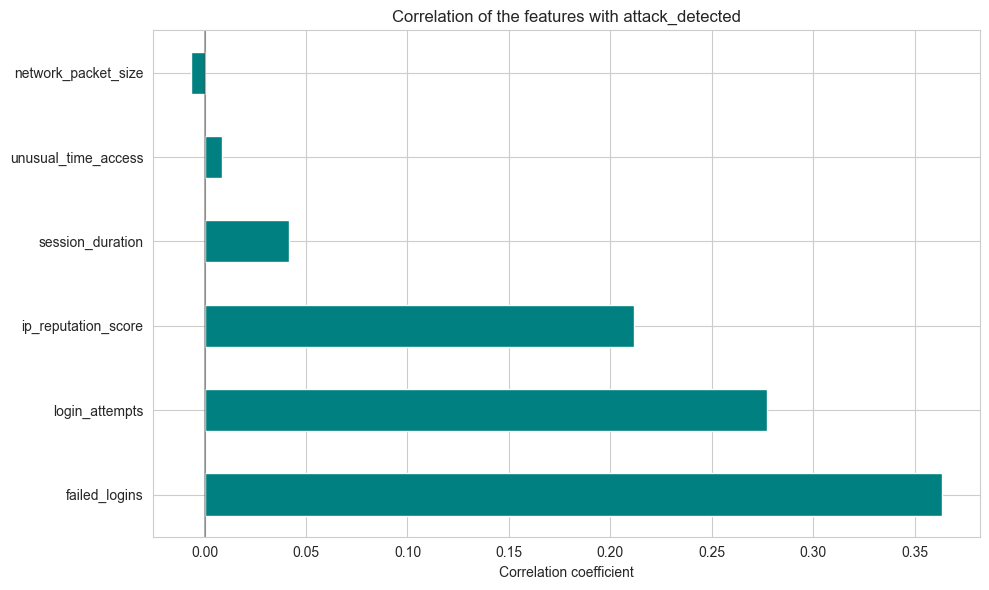

In [226]:
# Correlation with the target
numerical_features = [col for col in numeric_cols if col != 'attack_detected']
correlation_matrix = df[numerical_features + ['attack_detected']].corr()
target_correlation = correlation_matrix['attack_detected'].sort_values(ascending=False)
print(target_correlation)

# Visualization of the correlation with the target
plt.figure(figsize=(10, 6))
target_correlation.drop('attack_detected').plot(kind='barh', color='teal')
plt.title('Correlation of the features with attack_detected')
plt.xlabel('Correlation coefficient')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

**Box plots of the numerical features**

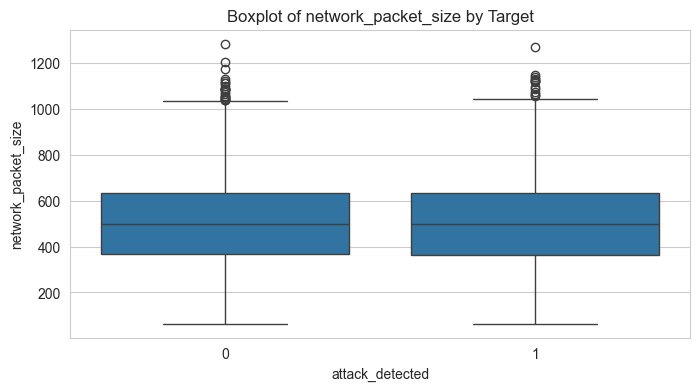

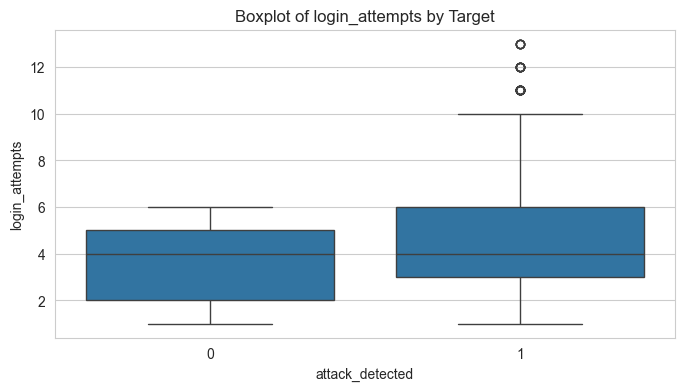

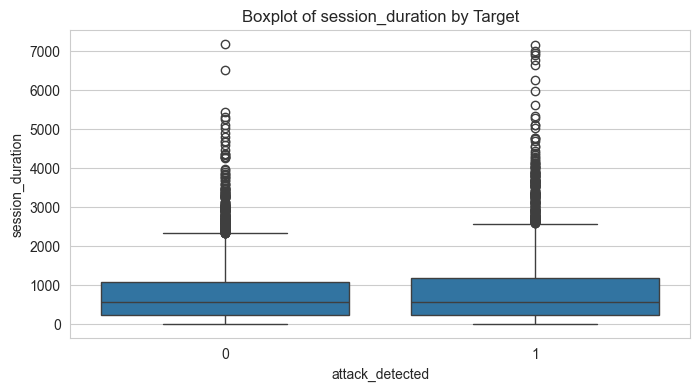

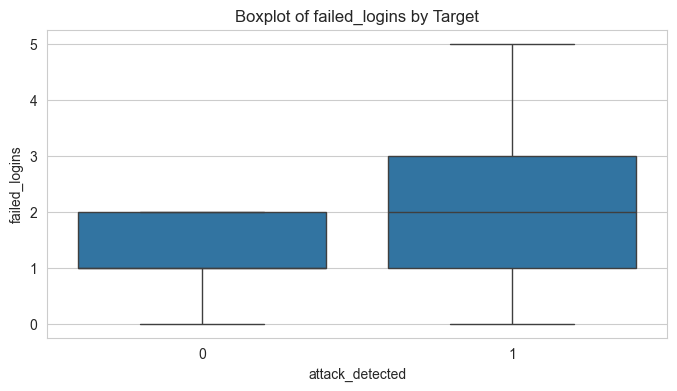

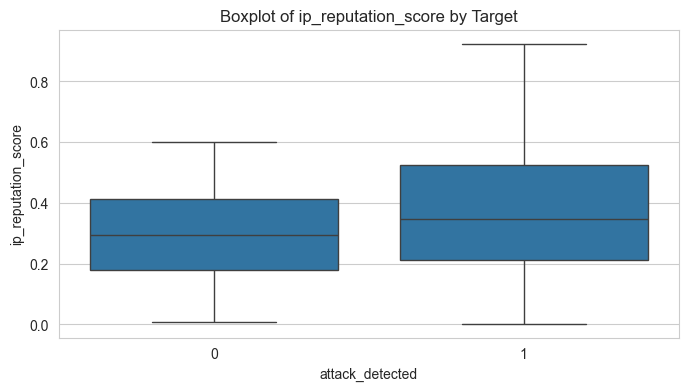

In [227]:
numerical_features = ['network_packet_size', 'login_attempts', 'session_duration', 'failed_logins', 'ip_reputation_score']

for feature in numerical_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='attack_detected', y=feature, data=df)
    plt.title(f'Boxplot of {feature} by Target')
    plt.show()

## Object features

**Protocol type**

Protocol type distribution
protocol_type
TCP     6624
UDP     2406
ICMP     507
Name: count, dtype: int64


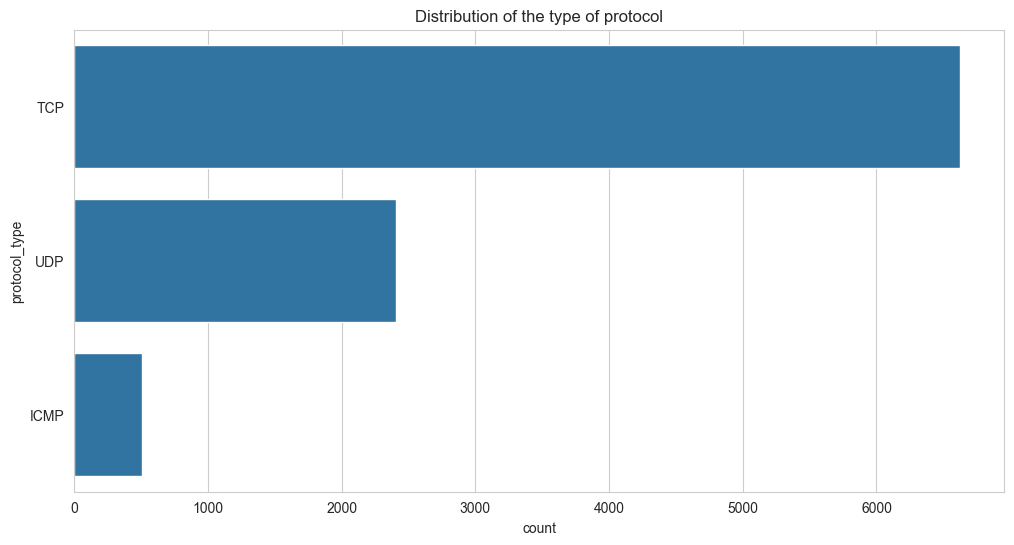

Text(0.5, 1.0, 'Protocol type pie chart')

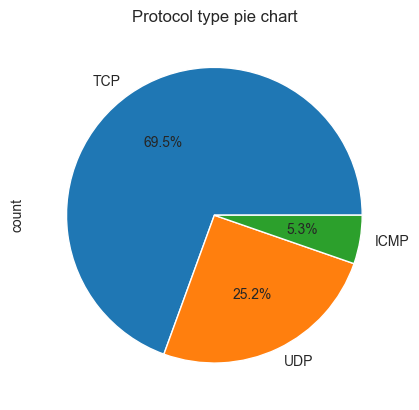

In [228]:
print("Protocol type distribution")
print(df['protocol_type'].value_counts(normalize=False))

plt.figure(figsize=(12,6))
sns.countplot(y='protocol_type', data=df, order=df['protocol_type'].value_counts().index)
plt.title('Distribution of the type of protocol')
plt.show()

df['protocol_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Protocol type pie chart')

**Encryption used**

Encryption used distribution
encryption_used
AES    4706
DES    2865
Name: count, dtype: int64


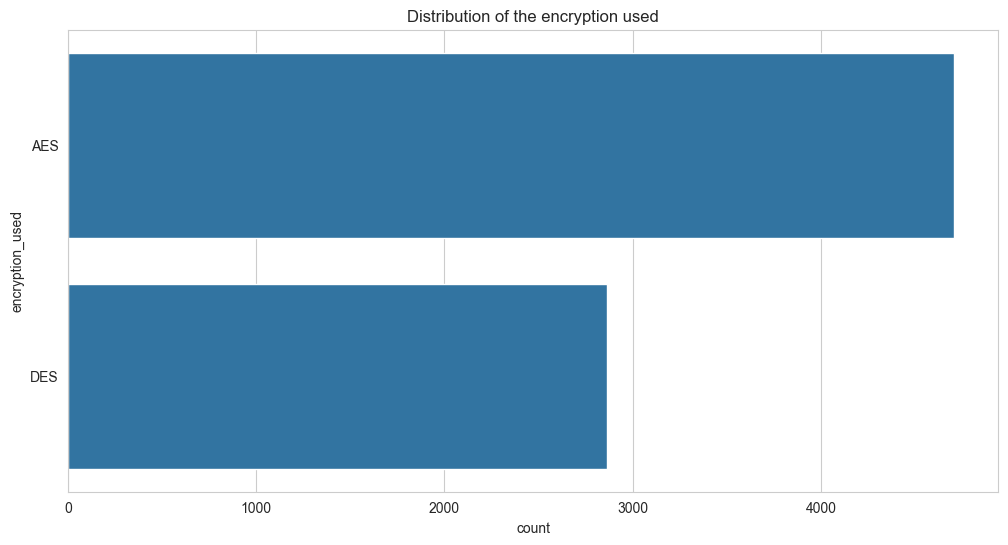

Text(0.5, 1.0, 'Encryption used pie chart')

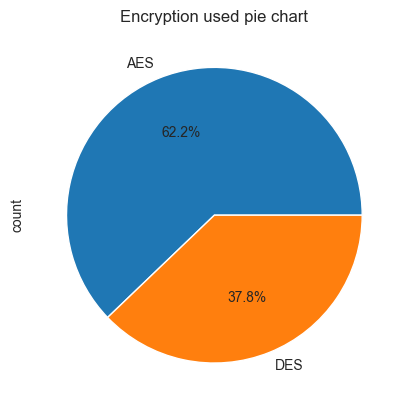

In [229]:
print("Encryption used distribution")
print(df['encryption_used'].value_counts(normalize=False))

plt.figure(figsize=(12,6))
sns.countplot(y='encryption_used', data=df, order=df['encryption_used'].value_counts().index)
plt.title('Distribution of the encryption used')
plt.show()

df['encryption_used'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Encryption used pie chart')

**Browser type**

Browser type distribution
browser_type
Chrome     5137
Firefox    1944
Edge       1469
Unknown     502
Safari      485
Name: count, dtype: int64


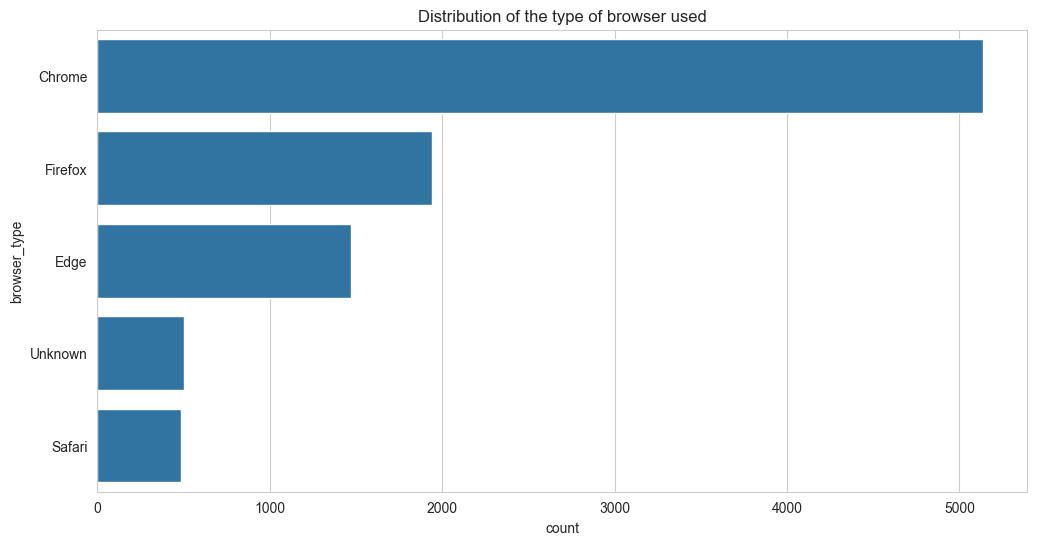

Text(0.5, 1.0, 'Browser type pie chart')

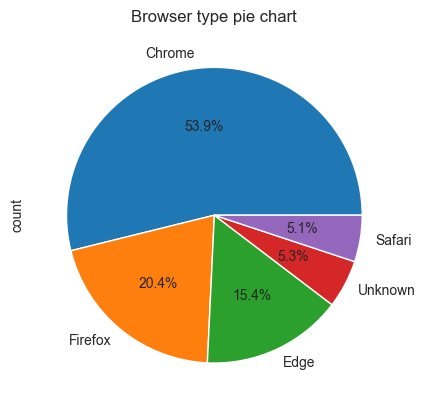

In [230]:
print("Browser type distribution")
print(df['browser_type'].value_counts(normalize=False))

plt.figure(figsize=(12,6))
sns.countplot(y='browser_type', data=df, order=df['browser_type'].value_counts().index)
plt.title('Distribution of the type of browser used')
plt.show()

df['browser_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Browser type pie chart')

**Cross analysis with attack_detected**

In [231]:
# Protocol_type vs Attack
protocol_attack = pd.crosstab(df['protocol_type'], df['attack_detected'], normalize='index') * 100
print("Protocol_type vs Attack (%):")
print(protocol_attack.round(2))

# Encryption_used vs Attack
encryption_attack = pd.crosstab(df['encryption_used'], df['attack_detected'], normalize='index') * 100
print("\nEncryption_used vs Attack (%):")
print(encryption_attack.round(2))

# Browser_type vs Attack
browser_attack = pd.crosstab(df['browser_type'], df['attack_detected'], normalize='index') * 100
print("\nBrowser_type vs Attack (%):")
print(browser_attack.round(2))

Protocol_type vs Attack (%):
attack_detected      0      1
protocol_type                
ICMP             58.78  41.22
TCP              55.27  44.73
UDP              54.61  45.39

Encryption_used vs Attack (%):
attack_detected      0      1
encryption_used              
AES              56.33  43.67
DES              54.66  45.34

Browser_type vs Attack (%):
attack_detected      0      1
browser_type                 
Chrome           57.13  42.87
Edge             56.23  43.77
Firefox          56.33  43.67
Safari           58.14  41.86
Unknown          26.89  73.11


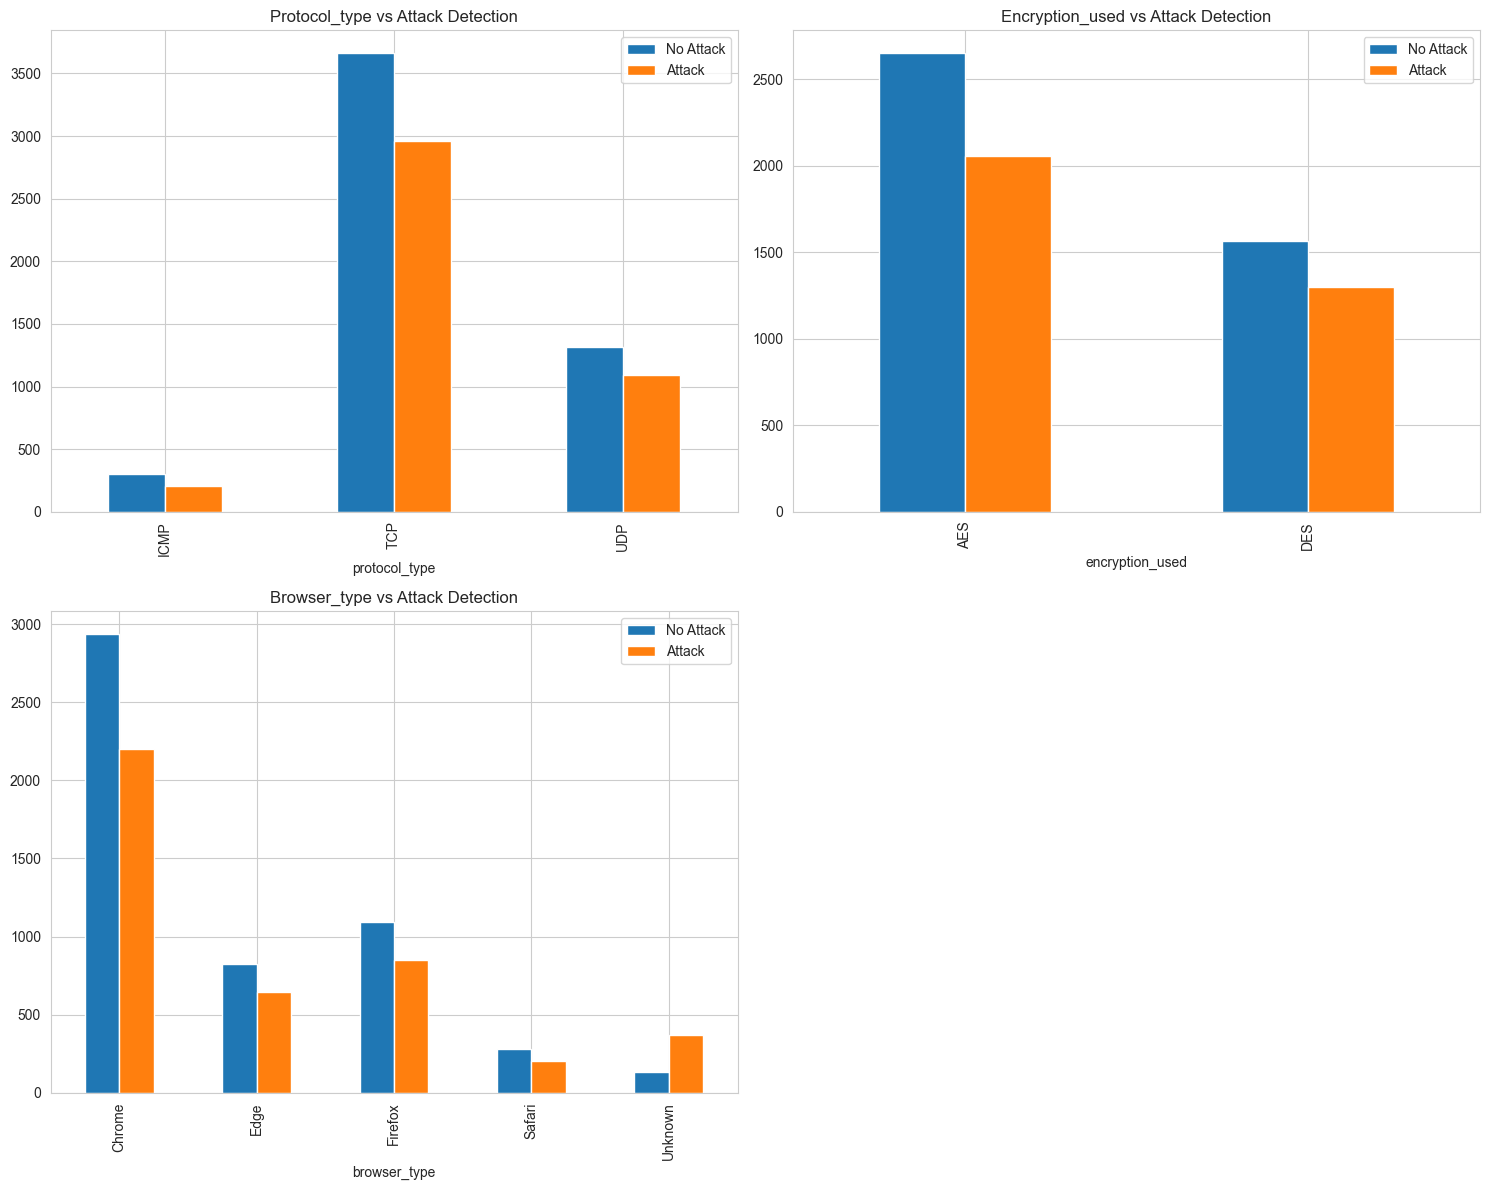

In [232]:
# Visualization of the cross-analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Protocol_type
pd.crosstab(df['protocol_type'], df['attack_detected']).plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Protocol_type vs Attack Detection')
axes[0,0].legend(['No Attack', 'Attack'])

# Encryption_used
pd.crosstab(df['encryption_used'], df['attack_detected']).plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Encryption_used vs Attack Detection')
axes[0,1].legend(['No Attack', 'Attack'])

# Browser_type
pd.crosstab(df['browser_type'], df['attack_detected']).plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Browser_type vs Attack Detection')
axes[1,0].legend(['No Attack', 'Attack'])

# Attack rate by category
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

### Pre-processing

**Handling missing values**

In [233]:
df['encryption_used'].fillna('Unknown', inplace=True)

C:\Users\itoda\AppData\Local\Temp\ipykernel_20096\651670891.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['encryption_used'].fillna('Unknown', inplace=True)


**Encode categorial features**

In [234]:
categorical_features = ['protocol_type', 'encryption_used', 'browser_type']

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

**Train/test split**

In [235]:
from sklearn.model_selection import train_test_split

X = df.drop(['attack_detected', 'session_id'], axis=1)

y = df['attack_detected']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (7629, 14), Test size: (1908, 14)


**Resampling analysis**

In [236]:
samplers = {
    "No Rebalancing": None,
    "Random OverSampling": RandomOverSampler(random_state=42),
    "Random UnderSampling": RandomUnderSampler(random_state=42)
}

In [237]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
conf_matrices = {}

for name, sampler in samplers.items():
    print(f"\n=== {name} ===")

    X_res, y_res = (X_train, y_train)
    if sampler:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    print("Class distribution after sampling:", Counter(y_res))

    model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')

    f1_scores, auc_scores = [], []
    conf_sum = np.zeros((2,2))

    for train_idx, val_idx in cv.split(X_res, y_res):
        X_tr, X_val = X_res.iloc[train_idx], X_res.iloc[val_idx]
        y_tr, y_val = y_res.iloc[train_idx], y_res.iloc[val_idx]


        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:,1]

        f1_scores.append(f1_score(y_val, y_pred))
        auc_scores.append(roc_auc_score(y_val, y_proba))
        conf_sum += confusion_matrix(y_val, y_pred)

    conf_avg = conf_sum / cv.get_n_splits()
    conf_matrices[name] = conf_avg

    results.append({
        'Method': name,
        'F1_mean': np.mean(f1_scores),
        'F1_std': np.std(f1_scores),
        'AUC_mean': np.mean(auc_scores),
        'AUC_std': np.std(auc_scores)
    })



=== No Rebalancing ===
Class distribution after sampling: Counter({0: 4218, 1: 3411})

=== Random OverSampling ===
Class distribution after sampling: Counter({0: 4218, 1: 4218})

=== Random UnderSampling ===
Class distribution after sampling: Counter({0: 3411, 1: 3411})


In [238]:
results_df = pd.DataFrame(results)
print("\n=== Cross-Validation Results ===")
print(results_df.round(3))


=== Cross-Validation Results ===
                 Method  F1_mean  F1_std  AUC_mean  AUC_std
0        No Rebalancing    0.866   0.011     0.887    0.008
1   Random OverSampling    0.865   0.002     0.888    0.003
2  Random UnderSampling    0.866   0.005     0.887    0.005


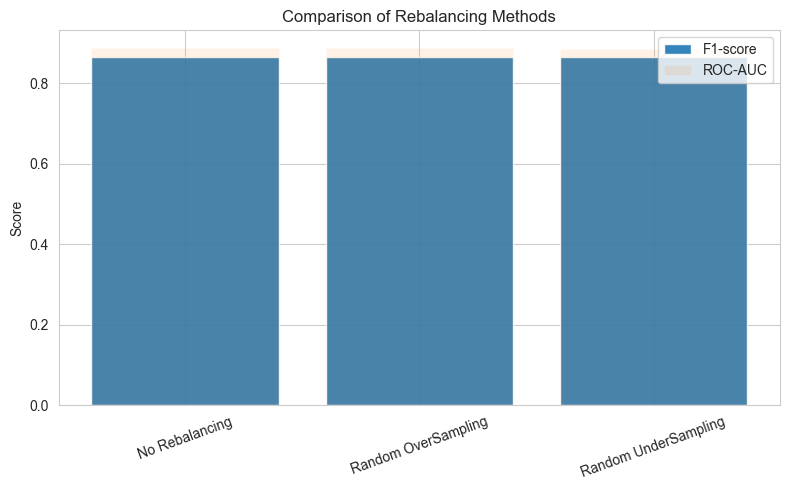

In [239]:
plt.figure(figsize=(8,5))
plt.bar(results_df['Method'], results_df['F1_mean'], alpha=0.9, label='F1-score')
plt.bar(results_df['Method'], results_df['AUC_mean'], alpha=0.1, label='ROC-AUC')
plt.title("Comparison of Rebalancing Methods")
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.legend()
plt.tight_layout()
plt.show()

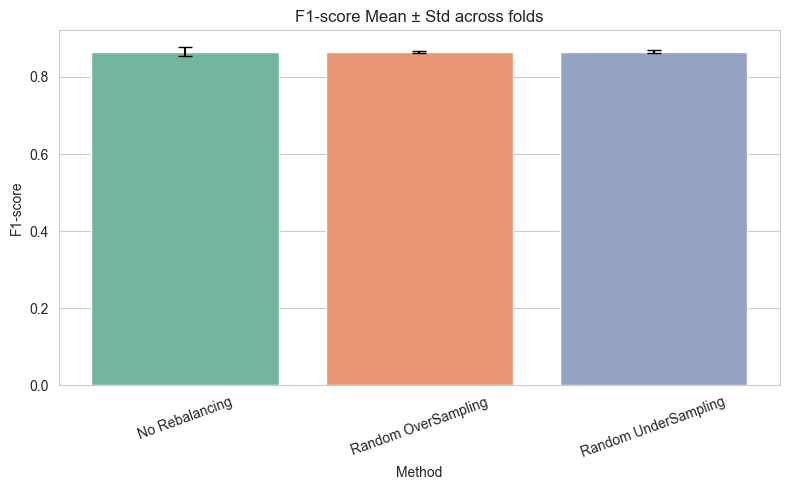

In [240]:
plt.figure(figsize=(8,5))
sns.barplot(x="Method", y="F1_mean", hue="Method", data=results_df, palette="Set2", errorbar=None, legend=False)
plt.errorbar(x=np.arange(len(results_df)), y=results_df["F1_mean"],
             yerr=results_df["F1_std"], fmt='none', ecolor='black', capsize=5)
plt.title("F1-score Mean ± Std across folds")
plt.ylabel("F1-score")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In this analysis, we tested several resampling techniques. However, the data is nearly balanced (imbalance ratio = 1:1.24), and resampling did not improve model performance. Therefore, we decided not to apply resampling in the upcoming models.

## 3. Formalization of the problem

The goal of this project is to develop a supervised model capable of detecting cybersecurity intrusion based on network traffic and user behavior

This task is a binary classification problem : the model must predict whether a given network session corresponds to a normal activity (0) or an attack (1).

The input features are : network_packet_size, protocol_type, encryption_used, login_attemps, session_duration, failed_logins, browser_type, unusual_time_access, ip_reputation_score

The output variable is attack_detected which is a binary variable that indicates if the session corresponds to an intrusion (1) or a normal activity (0).

As a baseline model, we will implement a Decision Tree Classifier. We chose this algorithm because it is easy to interpret and quick to train and it can handle both categorical and numerical data.

The baseline model will help us to have a reference performance, which will then enable us to measure the improvements achieved through the application of more advanced models or techniques

# Naive bayes

In [241]:
from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb_classifier.predict(X_test)
y_pred_proba_nb = nb_classifier.predict_proba(X_test)[:, 1]  # Probability of class 1

=== Naive Bayes Classifier Results ===

Accuracy: 0.8124
F1-Score: 0.7555
ROC-AUC: 0.8392

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1055
           1       0.91      0.65      0.76       853

    accuracy                           0.81      1908
   macro avg       0.84      0.80      0.80      1908
weighted avg       0.83      0.81      0.81      1908



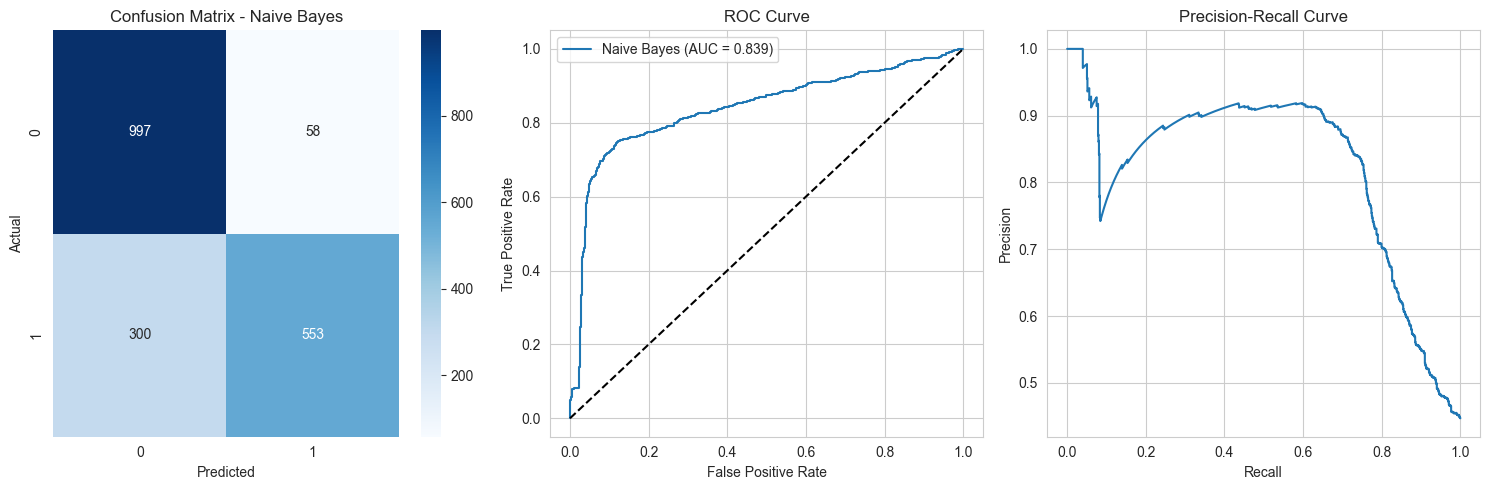

In [242]:
# Evaluate performance
print("=== Naive Bayes Classifier Results ===\n")

# Basic metrics
accuracy = accuracy_score(y_test, y_pred_nb)
f1 = f1_score(y_test, y_pred_nb)
auc_roc = roc_auc_score(y_test, y_pred_proba_nb)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {auc_roc:.4f}\n")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Confusion matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_nb)
plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {auc_roc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_nb)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

## Neural networks with no categorical variables

In [243]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [244]:
# Re-copy the dataset just in case
df = pd.read_csv('cybersecurity_intrusion_data.csv')

In [245]:
# Drop categorical columns and identifier
cols_to_drop = ['session_id', 'protocol_type', 'encryption_used', 'browser_type', 'attack_detected']

In [246]:
# Create features and target
X = df.drop(columns=cols_to_drop)
y=df['attack_detected']

In [247]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [248]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Building the Neural Network
- Input layer : Matches the number of features we have
- Hidden layers : We use ReLU activation
- Ouput layer : We use Sigmoid activation. It squeezes the output between 0 and 1, effectively giving us the probability of an attack

In [249]:
# 6. Initialize the model
model = Sequential()

# Input Layer + First Hidden Layer
# input_shape should be (number_of_features,)
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))

# Second Hidden Layer
model.add(Dense(32, activation='relu'))

# Dropout Layer (Prevents overfitting by randomly disabling neurons)
model.add(Dropout(0.3))

# Output Layer
# 1 neuron because it's binary classification (0 or 1)
# 'sigmoid' activation forces the output to be between 0 and 1
model.add(Dense(1, activation='sigmoid'))

# 7. Compile the model
model.compile(
    optimizer='adam',                 # Best general-purpose optimizer
    loss='binary_crossentropy',       # Standard loss function for binary classification
    metrics=['accuracy']              # We want to track accuracy
)

model.summary()

C:\Users\itoda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

Traning and evaluation
We use an Early Stopping callback. It stops the training automatically if the validation loss stops improving, which prevents the model frm overfitting

In [250]:
# 8. Define Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,          # Stop if no improvement after 5 epochs
    restore_best_weights=True
)

# 9. Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,           # Maximum epochs
    batch_size=32,       # Updates weights after every 32 rows
    callbacks=[early_stop],
    verbose=1
)

# 10. Evaluate
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# 11. Make Predictions
predictions = (model.predict(X_test_scaled) > 0.5).astype("int32")

Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7426 - loss: 0.5254 - val_accuracy: 0.8024 - val_loss: 0.4535
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8177 - loss: 0.4328 - val_accuracy: 0.8412 - val_loss: 0.4043
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8421 - loss: 0.3954 - val_accuracy: 0.8422 - val_loss: 0.3856
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8499 - loss: 0.3801 - val_accuracy: 0.8532 - val_loss: 0.3706
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8579 - loss: 0.3682 - val_accuracy: 0.8606 - val_loss: 0.3618
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8601 - loss: 0.3633 - val_accuracy: 0.8637 - val_loss: 0.3572
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638 - loss: 0.3515 - val_accuracy: 0.8627 - val_loss: 0.3519
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8646 - loss: 0.3492 - val_accuracy: 0.

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


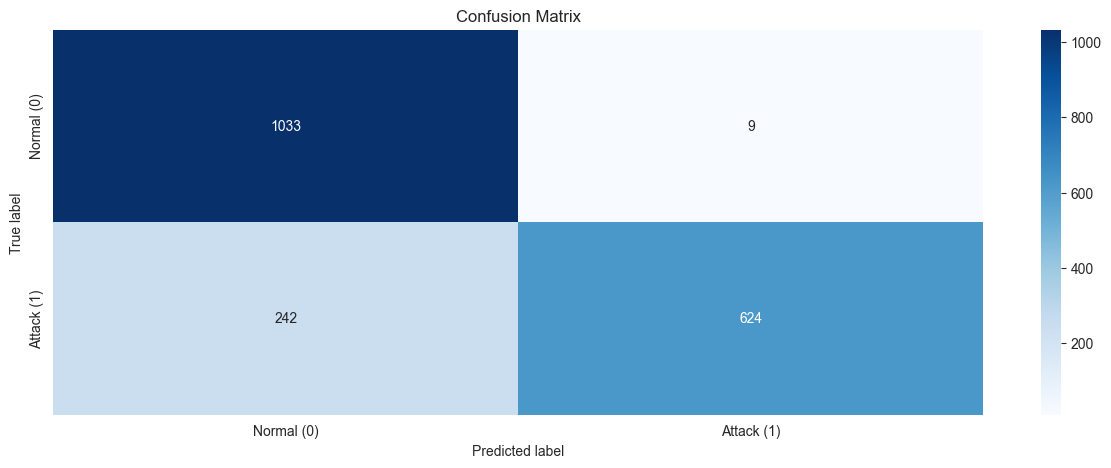


Classification Report:

              precision    recall  f1-score   support

      Normal       0.81      0.99      0.89      1042
      Attack       0.99      0.72      0.83       866

    accuracy                           0.87      1908
   macro avg       0.90      0.86      0.86      1908
weighted avg       0.89      0.87      0.86      1908



In [251]:
# Get the probabilities from the Neural Network
y_pred_proba_nn = model.predict(X_test_scaled)

# Convert Probbilities to classes (0 or 1)
y_pred_nn = (y_pred_proba_nn > 0.5).astype("int32")

# Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn)

# Plotting
plt.figure(figsize=(15, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal (0)', 'Attack (1)'],
            yticklabels=['Normal (0)', 'Attack (1)'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Calssification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_nn, target_names=['Normal', 'Attack']))


## Neural Networks with Feature engineering

In [252]:
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

In [253]:
# Load data
df = pd.read_csv('cybersecurity_intrusion_data.csv')

# Create 'Login Failure Rate'
df['login_failure_rate']=df['failed_logins']/(df['session_duration']+0.001)

# Packet Throughput (Data speed) : high packet data exfiltration or DDoS
df['packet_throughput'] = df['network_packet_size'] / (df['session_duration'] + 0.001)

# Failed login ratio : 10 failed out of 10 attempts (1.0) is a bot. 1 failed out of 100 is a clumsy user
df['failed_login_ratio'] = df['failed_logins'] / (df['login_attempts'] + 0.001)

# Critical Time Packet Volumetry : Large packets sent during "unusual times" are highly suspicious
df['critical_time_volume'] = df['unusual_time_access'] * df['network_packet_size']

# Login Frequency (Speed of attempts) : Rapid-fire log in attempts are suspicious
df['login_frequency'] = df['login_attempts'] / (df['session_duration'] + 0.001)

# Restore Categorical Variables (One-hot Encoding)
categorical_col = ['protocol_type', 'encryption_used']
df = pd.get_dummies(df, columns=categorical_col, drop_first=True, dtype=int)

cols_to_drop = ['session_id', 'browser_type', 'attack_detected']
X = df.drop(columns=cols_to_drop)
y = df['attack_detected']

print(f"Total Features: {X.shape[1]}")
print("Feature Names:", X.columns.tolist())
print(X.head())

Total Features: 14
Feature Names: ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access', 'login_failure_rate', 'packet_throughput', 'failed_login_ratio', 'critical_time_volume', 'login_frequency', 'protocol_type_TCP', 'protocol_type_UDP', 'encryption_used_DES']
   network_packet_size  login_attempts  session_duration  ip_reputation_score  \
0                  599               4        492.983263             0.606818   
1                  472               3       1557.996461             0.301569   
2                  629               3         75.044262             0.739164   
3                  804               4        601.248835             0.123267   
4                  453               5        532.540888             0.054874   

   failed_logins  unusual_time_access  login_failure_rate  packet_throughput  \
0              1                    0            0.002028           1.215049   
1              0     

In [254]:
# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [255]:
# Hyperparameter tuning setup
def build_model(hp):
    """
    This function builds a model, but instead of fixed numbers,
    we use 'hp' (HyperParameters) to define ranges.
    """
    model = keras.Sequential()

    # Tunable First Layer: Try between 32 and 128 neurons
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu', input_shape=(X_train_scaled.shape[1],)))

    # Tunable Dropout: Try dropping 20% or 50% of neurons
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(layers.Dropout(rate=hp_dropout))

    # Optional Second Layer: The tuner decides whether to add this layer or not
    if hp.Boolean("add_hidden_layer"):
        model.add(layers.Dense(units=32, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    # Tunable Learning Rate: Try 0.01 vs 0.001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [256]:
# Running the search
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='security_attack_tuning'
)

# Create an EarlyStopping callback to save time
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

print("Starting Hyperparameter Search...")
tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Reloading Tuner from my_dir\security_attack_tuning\tuner0.json
Starting Hyperparameter Search...


In [257]:
# Get Best model and results

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
Optimal number of units in the first layer: {best_hps.get('units')}
Optimal learning rate: {best_hps.get('learning_rate')}
Add hidden layer: {best_hps.get('add_hidden_layer')}
""")

# Build the model with the best hyperparameters and train it fully
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2)

# Final Evaluation
loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f"Final Tuned Test Accuracy: {accuracy*100:.2f}%")


The hyperparameter search is complete.
Optimal number of units in the first layer: 32
Optimal learning rate: 0.01
Add hidden layer: False

Epoch 1/100


C:\Users\itoda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7557 - loss: 0.5169 - val_accuracy: 0.7890 - val_loss: 0.4491
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8145 - loss: 0.4422 - val_accuracy: 0.8499 - val_loss: 0.3914
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8347 - loss: 0.4085 - val_accuracy: 0.8670 - val_loss: 0.3678
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8486 - loss: 0.3867 - val_accuracy: 0.8676 - val_loss: 0.3568
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8517 - loss: 0.3717 - val_accuracy: 0.8709 - val_loss: 0.3423
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8535 - loss: 0.3679 - val_accuracy: 0.8748 - val_loss: 0.3393
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8552 - loss: 0.3627 - val_accuracy: 0.8689 - val_loss: 0.3356
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8532 - loss: 0.3625 - val_accuracy: 0.8761

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


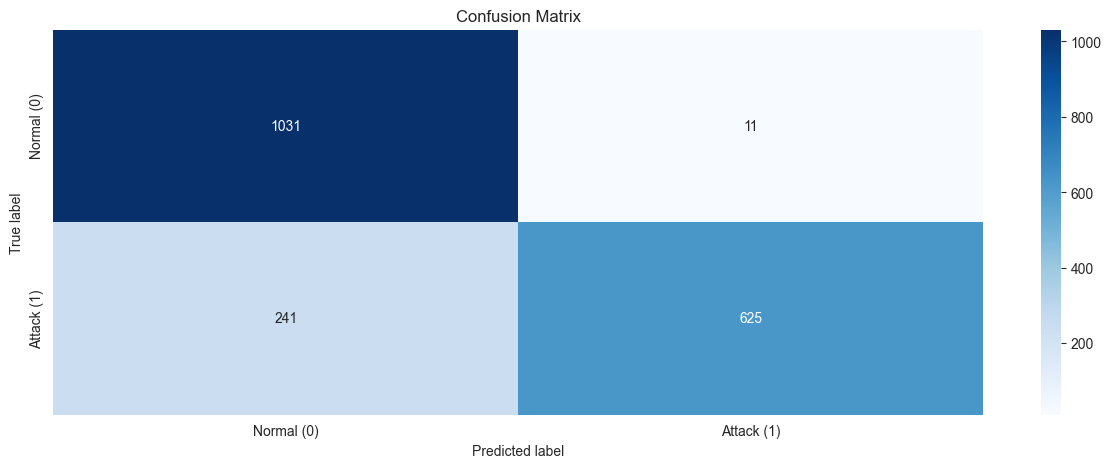


Classification Report:

              precision    recall  f1-score   support

      Normal       0.81      0.99      0.89      1042
      Attack       0.98      0.72      0.83       866

    accuracy                           0.87      1908
   macro avg       0.90      0.86      0.86      1908
weighted avg       0.89      0.87      0.86      1908



In [258]:
# Get the probabilities from the Neural Network
y_pred_proba_nn2 = best_model.predict(X_test_scaled)

# Convert Probbilities to classes (0 or 1)
y_pred_nn2 = (y_pred_proba_nn2 > 0.5).astype("int32")

# Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn2)

# Plotting
plt.figure(figsize=(15, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal (0)', 'Attack (1)'],
            yticklabels=['Normal (0)', 'Attack (1)'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Calssification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_nn2, target_names=['Normal', 'Attack']))


## Comparing all the models

### Decision Tree

In [259]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train
    model.fit(X_train, y_train)

    # Predict classes
    y_pred_dt = model.predict(X_test)

    # Predict probabilities (for ROC-AUC)
    y_proba_dt = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred_dt)
    f1 = f1_score(y_test, y_pred_dt)
    auc = roc_auc_score(y_test, y_proba_dt)

    # Display results
    print(f"=== {model.__class__.__name__} ===")
    print(f"F1-score: {f1:.3f}")
    print(f"AUC: {auc:.3f}")
    print(f"Accuracy: {acc:.3f}")
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred_dt))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_dt)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal (0)', 'Attack (1)'],
                yticklabels=['Normal (0)', 'Attack (1)'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

=== Sequential ===
F1-score: 0.764
AUC: 0.782
Accuracy: 0.782

Classification report:

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1042
           1       0.75      0.78      0.76       866

    accuracy                           0.78      1908
   macro avg       0.78      0.78      0.78      1908
weighted avg       0.78      0.78      0.78      1908



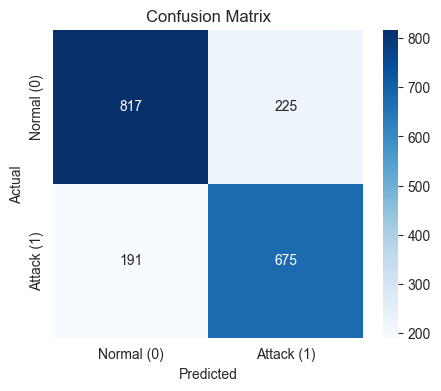

In [260]:
model_decision_tree = DecisionTreeClassifier(random_state=42)
model_decision_tree.fit(X_train, y_train)

# Predict classes
y_pred_dt = model_decision_tree.predict(X_test)

# Predict probabilities (for ROC-AUC)
y_proba_dt = model_decision_tree.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)
auc = roc_auc_score(y_test, y_proba_dt)

# Display results
print(f"=== {model.__class__.__name__} ===")
print(f"F1-score: {f1:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Accuracy: {acc:.3f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_dt))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal (0)', 'Attack (1)'],
                yticklabels=['Normal (0)', 'Attack (1)'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


 ### XBGOOST

In [261]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

ratio = (y_train==0).sum()/(y_train==1).sum()
param_dist = {
    'n_estimators': st.randint(200, 600),
    'max_depth': st.randint(3, 6),
    'learning_rate': st.uniform(0.005, 0.05),
    'subsample': st.uniform(0.6, 0.4),
    'colsample_bytree': st.uniform(0.6, 0.4),
    'min_child_weight': st.randint(1, 6),
    'gamma': st.uniform(0, 0.3),
    'reg_alpha': st.uniform(0, 0.1),
    'reg_lambda': st.uniform(1, 2),
    'scale_pos_weight': [1, ratio,3, 5, 8, 10]
}

rand = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=80,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
rand.fit(X_train, y_train)
best_model = rand.best_estimator_
y_pred_xgb = best_model.predict(X_test)

print("Best parameters:", rand.best_params_)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


C:\Users\itoda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:199: UserWarning: [11:09:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': np.float64(0.7737807377953085), 'gamma': np.float64(0.07610465216194162), 'learning_rate': np.float64(0.025260104339070857), 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 347, 'reg_alpha': np.float64(0.011881791626807192), 'reg_lambda': np.float64(1.2350524935542098), 'scale_pos_weight': 1, 'subsample': np.float64(0.8976846627773192)}


### Random Forest

=== Sequential ===
F1-score: 0.830
AUC: 0.869
Accuracy: 0.865

Classification report:

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1042
           1       0.97      0.72      0.83       866

    accuracy                           0.87      1908
   macro avg       0.89      0.85      0.86      1908
weighted avg       0.88      0.87      0.86      1908



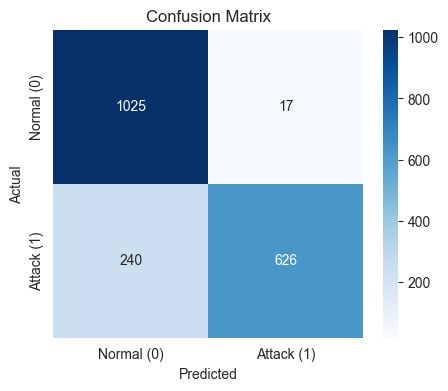

In [262]:
model_random_forest = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
model_random_forest.fit(X_train, y_train)
# Predict classes
y_pred_rf = model_random_forest.predict(X_test)

# Predict probabilities (for ROC-AUC)
y_proba_rf = model_random_forest.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
auc = roc_auc_score(y_test, y_proba_rf)

# Display results
print(f"=== {model.__class__.__name__} ===")
print(f"F1-score: {f1:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Accuracy: {acc:.3f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal (0)', 'Attack (1)'],
                yticklabels=['Normal (0)', 'Attack (1)'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [263]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 30)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best hyperparameters:", random_search.best_params_)
print("Best F1-score:", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'class_weight': None, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 108}
Best F1-score: 0.8347611172991297


=== Sequential ===
F1-score: 0.833
AUC: 0.871
Accuracy: 0.869

Classification report:

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1042
           1       0.99      0.72      0.83       866

    accuracy                           0.87      1908
   macro avg       0.90      0.86      0.86      1908
weighted avg       0.89      0.87      0.87      1908



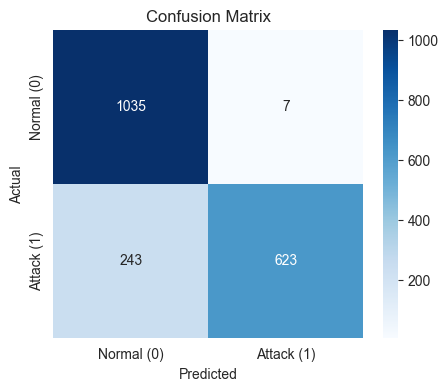

In [264]:
best_rf = random_search.best_estimator_
# Predict classes
y_pred_rf2 = best_rf.predict(X_test)

# Predict probabilities (for ROC-AUC)
y_proba_rf2 = best_rf.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_rf2)
f1 = f1_score(y_test, y_pred_rf2)
auc = roc_auc_score(y_test, y_proba_rf2)

# Display results
print(f"=== {model.__class__.__name__} ===")
print(f"F1-score: {f1:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Accuracy: {acc:.3f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_rf2))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf2)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal (0)', 'Attack (1)'],
                yticklabels=['Normal (0)', 'Attack (1)'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Comparison graph

In [270]:
predictions = {
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf2,
    'XGBoost': y_pred_xgb,
    'Neural Network (no categorial)': y_pred_nn,
    'Neural Network with feature engineering': y_pred_nn2
}

true_labels = y_test

In [271]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
results_list = []

for model_name, preds in predictions.items():
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='binary')
    rec = recall_score(y_test, preds, average='binary')
    results_list.append({
        'Model': model_name,
        'Accuracy': acc,
        'F1 Score': f1,
        'Recall': rec,

    })

# Create a clean DataFrame
df_results = pd.DataFrame(results_list)
print("Model Comparison Table")
print(df_results)
print("\n")

Model Comparison Table
                                     Model  Accuracy  F1 Score    Recall
0                            Decision Tree  0.781971  0.764439  0.779446
1                            Random Forest  0.868973  0.832888  0.719400
2                                  XGBoost  0.869497  0.832549  0.714781
3           Neural Network (no categorial)  0.868449  0.832555  0.720554
4  Neural Network with feature engineering  0.867925  0.832224  0.721709




In [272]:
# Melt the dataframe to make it easy to plot side-by-side bars
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

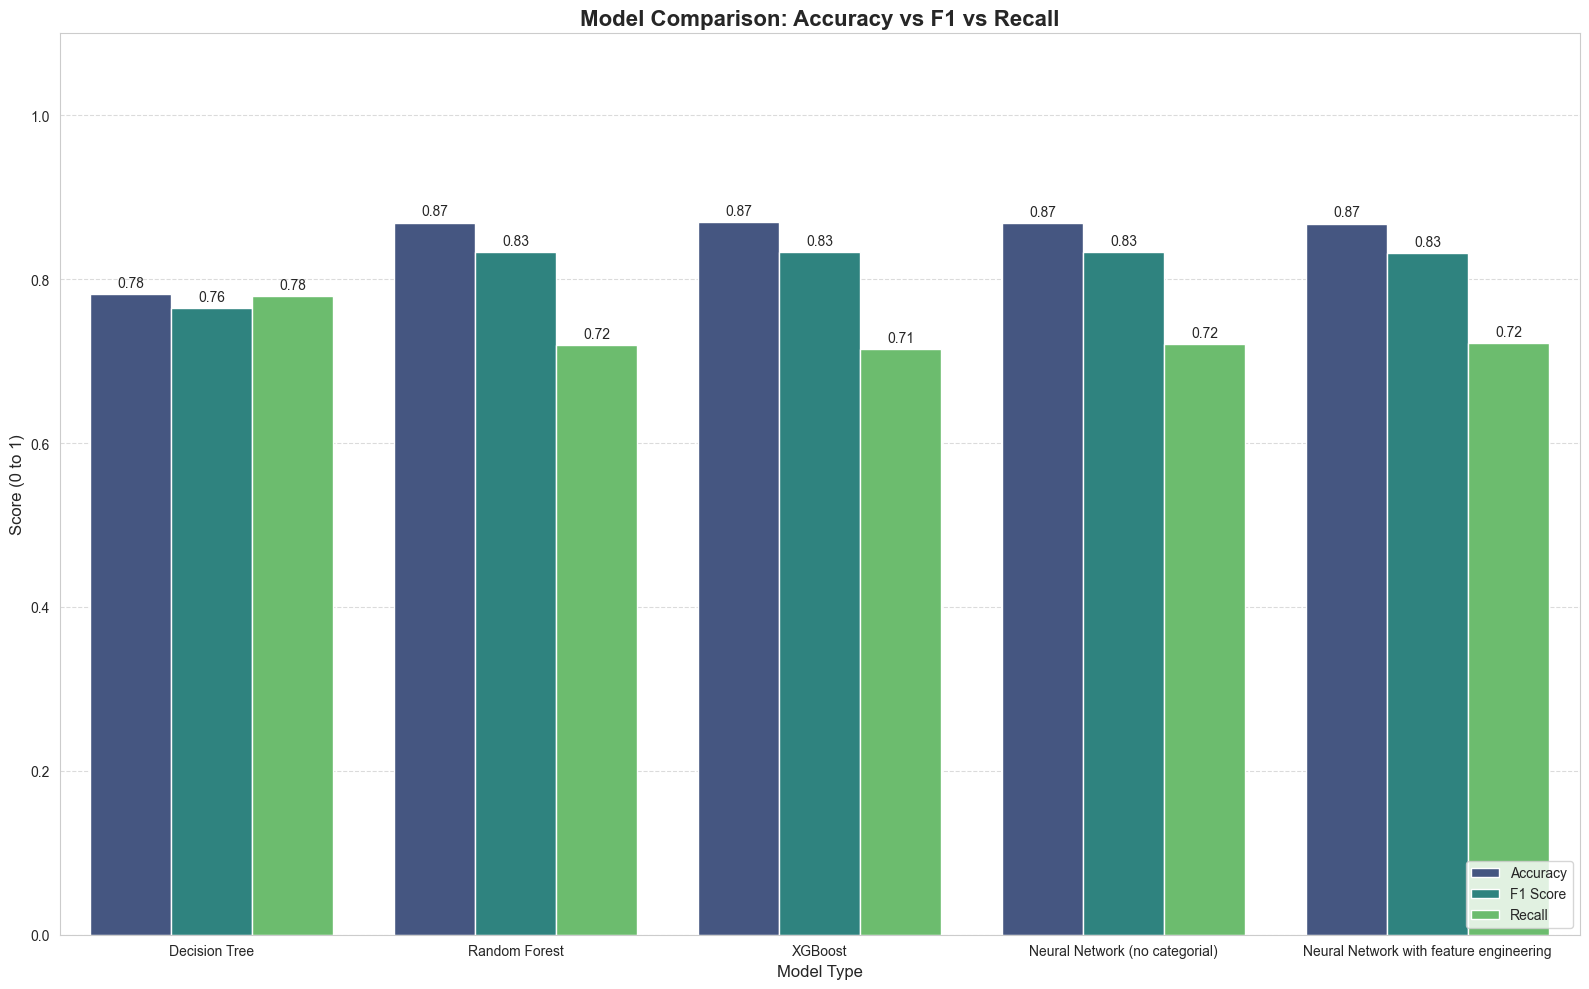

In [273]:
plt.figure(figsize=(16,10))
plot = sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette='viridis')

# Add titles and labels
plt.title('Model Comparison: Accuracy vs F1 vs Recall', fontsize=16, fontweight='bold')
plt.ylabel('Score (0 to 1)', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')

for container in plot.containers:
    plot.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

# Scatter plot

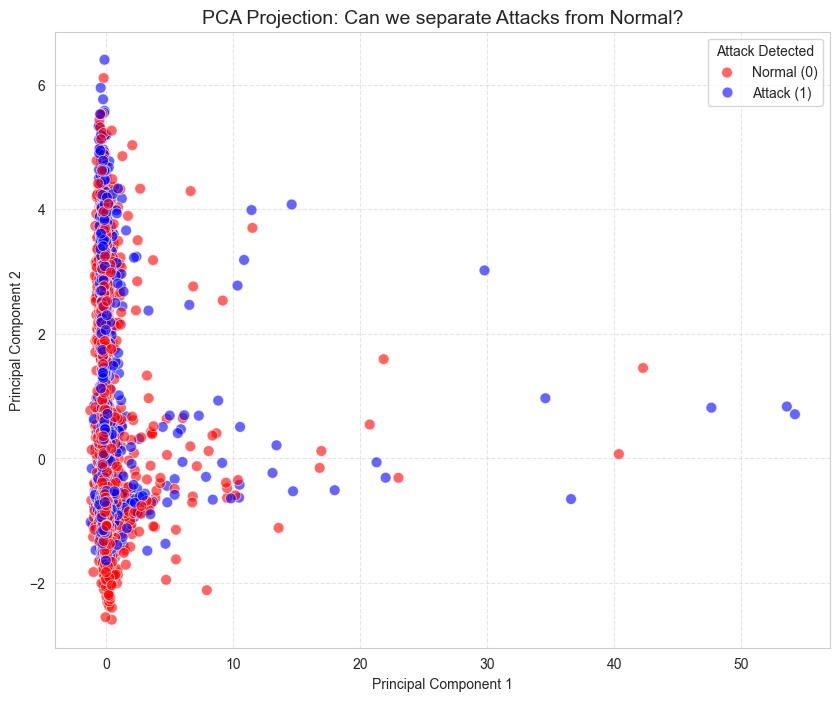

Total Information Retained: 24.48%


In [275]:
from sklearn.decomposition import PCA

# Re-load the data
df = pd.read_csv('cybersecurity_intrusion_data.csv')

# Re-add the engineered features
df['login_failure_rate'] = df['failed_logins'] / (df['session_duration'] + 0.001)
df['packet_throughput'] = df['network_packet_size'] / (df['session_duration'] + 0.001)
df['failed_login_ratio'] = df['failed_logins'] / (df['login_attempts'] + 0.001)
df['critical_time_volume'] = df['unusual_time_access'] * df['network_packet_size']
df['login_frequency'] = df['login_attempts'] / (df['session_duration'] + 0.001)

# Encode categorical colums
categorical_cols = ['protocol_type', 'encryption_used', 'browser_type']

# dtype=int ensure we get 0 and 1, not False/True
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

# Define X and y
cols_to_drop = ['session_id', 'attack_detected']
X = df_encoded.drop(columns=cols_to_drop)
y = df_encoded['attack_detected']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualization
df_viz = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_viz['Label'] = y.values

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Label',
    data=df_viz,
    palette=['blue', 'red'], # Blue=Normal, Red=Attack
    alpha=0.6,
    s=60
)

plt.title('PCA Projection: Can we separate Attacks from Normal?', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Attack Detected', labels=['Normal (0)', 'Attack (1)'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print Variance to see how much info we kept
print(f"Total Information Retained: {sum(pca.explained_variance_ratio_)*100:.2f}%")